In [1]:
from jqdata import *
from jqfactor import *
import numpy as np
import pandas as pd
import datetime
from sklearn.linear_model import LogisticRegression

In [40]:
mystart = '2014-01-01'
myend = '2014-01-31'
data = pd.DataFrame()

In [41]:
#人民币兑换美元的现汇买入价(日级)
q1 = query(
    macro.MAC_RMB_EXCHANGE_RATE.day,
    macro.MAC_RMB_EXCHANGE_RATE.cash_buy_rate   
    ).filter(
    macro.MAC_RMB_EXCHANGE_RATE.currency_id=='40',
    mystart<=macro.MAC_RMB_EXCHANGE_RATE.day
    ).filter(
    macro.MAC_RMB_EXCHANGE_RATE.day<=myend
    )
fx = macro.run_query(q1).sort_values(by='day')
fx['year_month'] = fx['day'].apply(lambda x:x[0:7])
fx['yyyymm'] = fx['year_month'].apply(lambda x:datetime.datetime.strptime(x,"%Y-%m"))
data['fx'] = np.array(fx.groupby('yyyymm').head(1).cash_buy_rate)
data['yyyymm01'] = np.array(fx['yyyymm'].unique())

In [42]:
#M2同比增长率月度数据
q2 = query(
    macro.MAC_MONEY_SUPPLY_MONTH.stat_month,
    macro.MAC_MONEY_SUPPLY_MONTH.m2_yoy   
    ).filter(
    mystart[0:7]<=macro.MAC_MONEY_SUPPLY_MONTH.stat_month
    ).filter(
    macro.MAC_MONEY_SUPPLY_MONTH.stat_month<=myend[0:7]
    )
m2 = macro.run_query(q2).sort_values(by='stat_month')
data['m2_yoy'] = np.array(m2['m2_yoy'])

In [43]:
#CPI同比增速月度数据
q3 = query(
    macro.MAC_CPI_MONTH.stat_month,
    macro.MAC_CPI_MONTH.yoy 
    ).filter(
    mystart[0:7]<=macro.MAC_CPI_MONTH.stat_month,
    macro.MAC_CPI_MONTH.area_code=='701001'
    ).filter(
    macro.MAC_CPI_MONTH.stat_month<=myend[0:7]
    )
cpi = macro.run_query(q3).sort_values(by='stat_month')
data['cpi_yoy'] = np.array(cpi['yoy'])

In [45]:
#沪深300
hs300 = get_price('000300.XSHG',start_date=mystart,end_date=myend,frequency='1d',fields='close',fq='pre')
hs300['year_month'] = np.array((pd.DataFrame([*map(str,hs300.index)])[0]).apply(lambda x:x[0:7]))
hs300['yyyymm'] = hs300['year_month'].apply(lambda x:datetime.datetime.strptime(x,"%Y-%m"))
data['hs300'] = np.array(hs300.groupby('yyyymm').head(1).close)
#中证500
zz500 = get_price('000905.XSHG',start_date=mystart,end_date=myend,frequency='1d',fields='close',fq='pre')
zz500['year_month'] = np.array((pd.DataFrame([*map(str,zz500.index)])[0]).apply(lambda x:x[0:7]))
zz500['yyyymm'] = zz500['year_month'].apply(lambda x:datetime.datetime.strptime(x,"%Y-%m"))
data['zz500'] = np.array(zz500.groupby('yyyymm').head(1).close)
#中证1000
zz1000 = get_price('000852.XSHG',start_date=mystart,end_date=myend,frequency='1d',fields='close',fq='pre')
zz1000['year_month'] = np.array((pd.DataFrame([*map(str,zz1000.index)])[0]).apply(lambda x:x[0:7]))
zz1000['yyyymm'] = zz1000['year_month'].apply(lambda x:datetime.datetime.strptime(x,"%Y-%m"))
data['zz1000'] = np.array(zz1000.groupby('yyyymm').head(1).close)

In [31]:
X = pd.DataFrame()
for col in ['fx','m2_yoy','cpi_yoy']:
    s = standardlize(data[col],inf2nan=True,axis=0)
    X[col] = np.array(s)

In [164]:
Y = pd.DataFrame()
for col in ['hs300','zz500','zz1000']:
    new_col = col+'ret'
    data[new_col] = data[col]/data[col].shift(1)-1
data = data.dropna()
Y['label'] = np.array([*map(int,data.hs300ret<data.zz500ret)])

In [165]:
def logit(X,Y,window):
    pre_list = []
    y_new = Y.iloc[window+1:]
    for i in range(len(Y)-window):
        x_old = X.iloc[i:i+window]
        x_new = np.array(X.iloc[i+window]).reshape(1,-1)
        y = Y.iloc[i+1:i+window+1]
        fit = LogisticRegression().fit(x_old,y)
        pre_list.append(fit.predict(x_new))
    score = float(np.sum((y_new-np.array(pre_list[:-1]).reshape(-1,1))==0))/len(y_new)*100
    return score

In [166]:
lst = []
for i in range(10,40):
    lst.append(logit(X,Y,i))

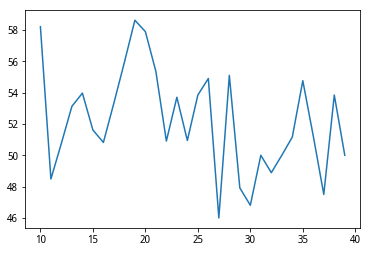

In [167]:
plt.plot(range(10,40),lst)

In [244]:
def get_month_firstday():
    '''
    返回：datetime格式的所有月初交易日
    '''
    day_lst = []
    month_lst = []
    year_lst = np.unique([i.year for i in get_all_trade_days()])
    for year in year_lst:
        for date in get_all_trade_days():
            if date.year==year:
                if len(month_lst)==12:
                    month_lst = []
                    break
                else:
                    if date.month not in month_lst:
                        day_lst.append(date)
                        month_lst.append(date.month)
    return day_lst

In [24]:
mystart = '2007-01-01'
myend = '2022-09-30'

In [25]:
hs300 = get_price('000300.XSHG',start_date=mystart,end_date=myend,frequency='1d',fields='close',fq='pre')
hs300['hs300'] = hs300.close/hs300.close[0]
zz500 = get_price('000905.XSHG',start_date=mystart,end_date=myend,frequency='1d',fields='close',fq='pre')
zz500['zz500'] = zz500.close/zz500.close[0]
zz1000 = get_price('000852.XSHG',start_date=mystart,end_date=myend,frequency='1d',fields='close',fq='pre')
zz1000['zz1000'] = zz1000.close/zz1000.close[0]

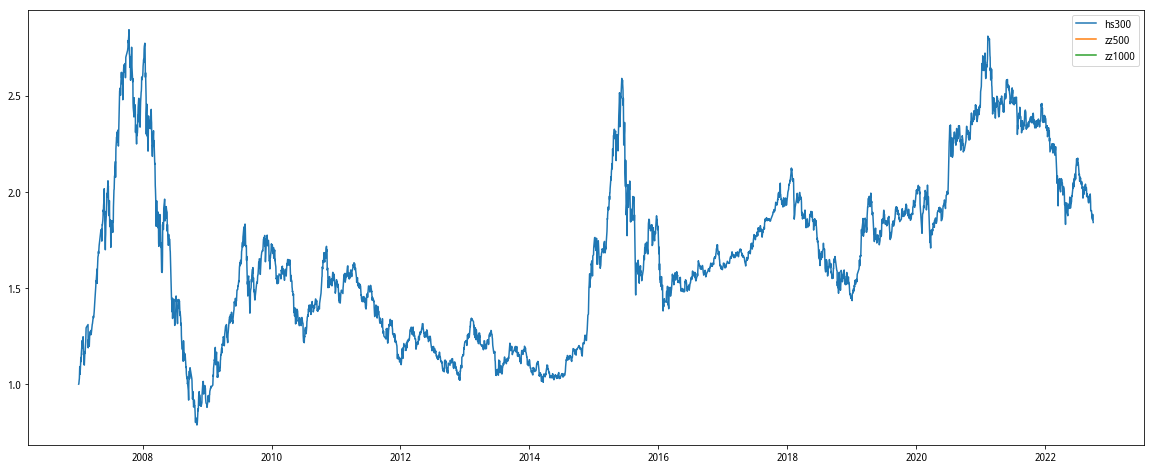

In [26]:
plt.figure(figsize=(20,8))
plt.plot(hs300.hs300,label='hs300')
plt.plot(zz500.zz500,label='zz500')
plt.plot(zz1000.zz1000,label='zz1000')
plt.legend()

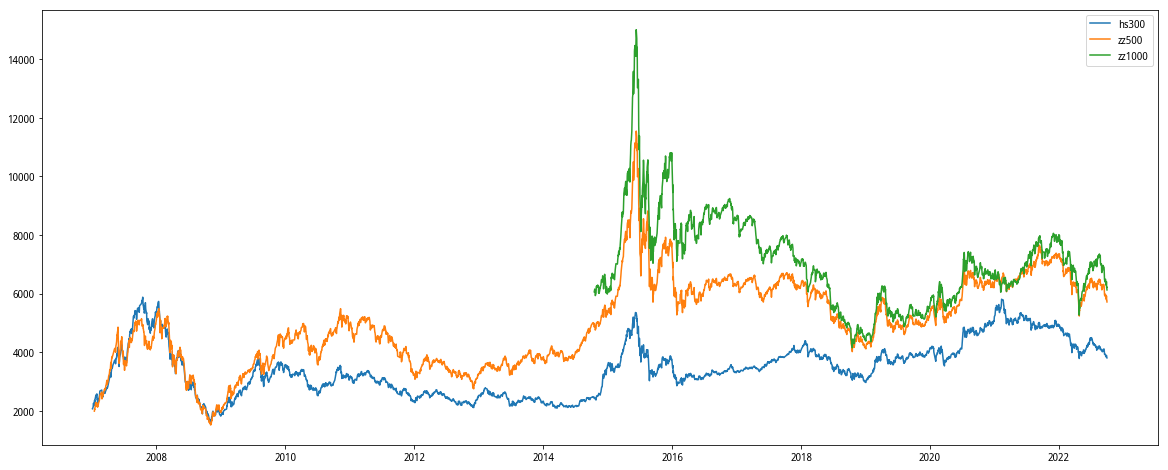

In [27]:
plt.figure(figsize=(20,8))
plt.plot(hs300.close,label='hs300')
plt.plot(zz500.close,label='zz500')
plt.plot(zz1000.close,label='zz1000')
plt.legend()